## 2D Data modelling
I am going to work on a ml model to predict prices using  neighborhood, location and size of our houses and the type of houses is apartments

In [67]:
# Importing our varibales
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns

# Machine learning: regression model + metrics
from sklearn.linear_model import LinearRegression, Ridge 
from sklearn.metrics import mean_absolute_error
from sklearn.utils.validation import check_is_fitted 

print("All requirements satisfied!")

All requirements satisfied!


## Preparing our data
Importing
Had intended to use the whole data but noticed that our "nairobi-apts-2.csv" is great for our model

In [68]:
# Our wrangle function
def wrangle(filepath):
    """
    Reads a CSV file into a pandas DataFrame.
    
    Parameters:
        filepath (str): Path to the CSV file.
        
    Returns:
        pd.DataFrame: Loaded DataFrame.
    """

    df = pd.read_csv(filepath)

    # Convert all column names to lowercase
    df.columns = [col.lower() for col in df.columns]

    # drop all columns we dont need
    df.drop(columns=["house_id", "lot_size_sqft", "house_tax_rate_%", "year_built"], inplace=True)

    # add a price_usd column 
    df["house_price_usd"] = round(df["house_price_ksh"] / 120, 2)
    
    # drop columns that might allow leakage
    df.drop(columns=["house_price_ksh", "price_change_since_2020_ksh", "price_2020_ksh", "price_2021_ksh", "price_2022_ksh", "price_2023_ksh", "price_2024_ksh"], inplace=True)
    
    # drop columns with low and high cardinality
    df.drop(columns=["proximity_to_city_km", "bedrooms", "bathrooms"], inplace=True)

    # mask out df down to only apartments
    mask_apt = df["type_of_house"] == "Apartment"

    # we drop apt as its low cardinality
    df.drop(columns="type_of_house", inplace=True)

    df = df[mask_apt]

    return df


In [69]:
df = wrangle("../data/raw/nairobi-apts-2.csv")
df.head()


,location,city_town,house_price_usd
3,Nairobi,Karen,502163.89
5,Malindi,Mambrui,417363.12
7,Mombasa,Likoni,762887.93
18,Nairobi,Karen,683379.40
29,Nakuru,London,790637.59


In [70]:
# check unique values in our categorical data 
for col in ['location', 'city_town']:
    print(f"{col} has {df[col].nunique()} unique categories")
    print(df[col].value_counts().head(), "\n")


location has 10 unique categories
location
Eldoret    245
Kisumu     228
Mombasa    224
Nairobi    221
Nyeri      220
Name: count, dtype: int64 

city_town has 50 unique categories
city_town
Kiamunyi       62
Pioneer        57
Nyamasaria     55
West Indies    54
Karen          53
Name: count, dtype: int64 



In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2185 entries, 3 to 10993
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   location         2185 non-null   object 
 1   city_town        2185 non-null   object 
 2   house_price_usd  2185 non-null   float64
dtypes: float64(1), object(2)
memory usage: 68.3+ KB


## Explore our data

Apartment Price Prediction Project – Visualization

Check distribution of our price in usd

Text(0.5, 1.0, 'Distribution of Apartment Prices')

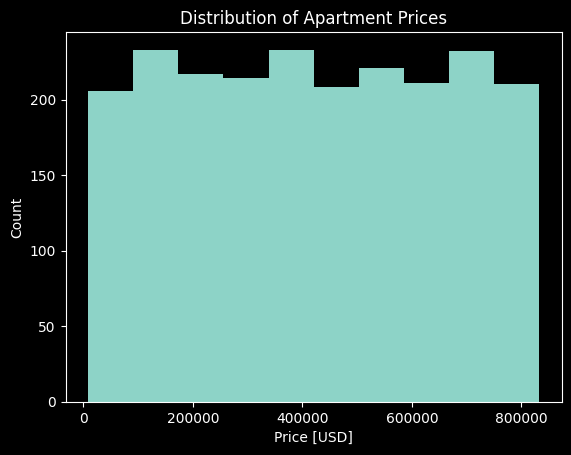

In [72]:
fig, ax = plt.subplots() 

# Plot the histogram on the axes object
ax.hist(df["house_price_usd"]) 

# Label axes using the axes 
ax.set_xlabel("Price [USD]")
ax.set_ylabel("Count")


# Add title 
ax.set_title("Distribution of Apartment Prices")

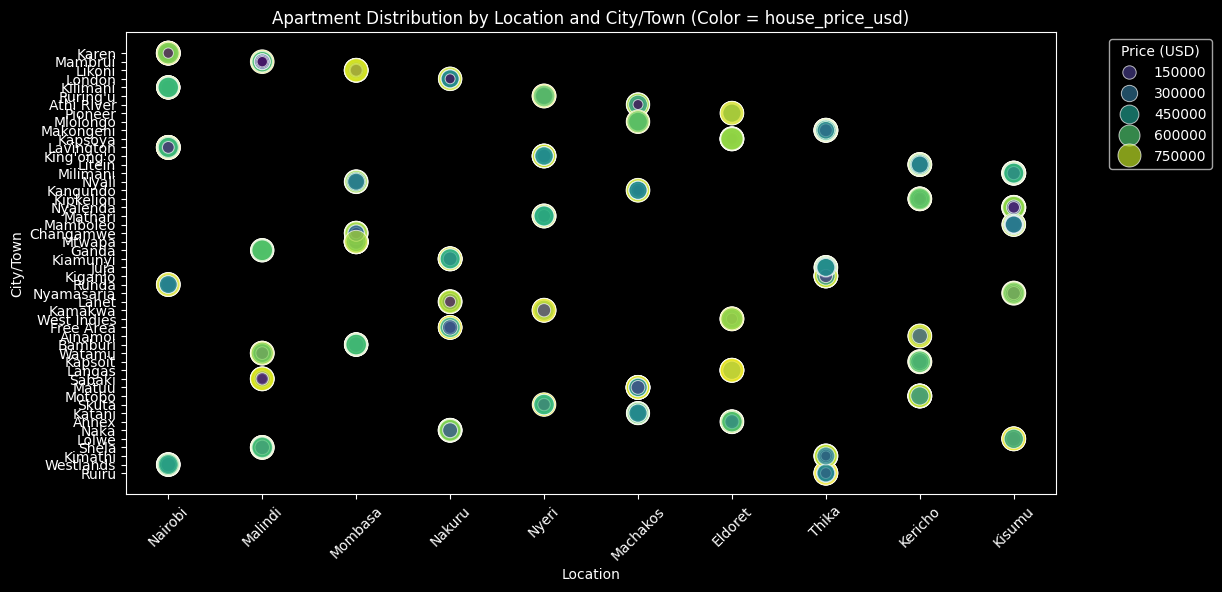

In [73]:
# Copy dataframe for plotting
df_plot = df[['location', 'city_town', 'house_price_usd']].copy()

# Create a scatter plot with categorical axes
plt.figure(figsize=(12, 6))
sns.scatterplot(
    data=df_plot,
    x='location',
    y='city_town',
    hue='house_price_usd',       # Color represents price
    palette='viridis',
    size='house_price_usd',      # Optional: size also reflects price
    sizes=(50, 300),       # Min and max point sizes
    alpha=0.7
)

plt.xticks(rotation=45)
plt.xlabel('Location')
plt.ylabel('City/Town')
plt.title('Apartment Distribution by Location and City/Town (Color = house_price_usd)')
plt.legend(title='Price (USD)', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

## Split 
split our data into features and targets ready for model build

In [74]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2185 entries, 3 to 10993
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   location         2185 non-null   object 
 1   city_town        2185 non-null   object 
 2   house_price_usd  2185 non-null   float64
dtypes: float64(1), object(2)
memory usage: 68.3+ KB


In [75]:
# split our data into feature matrix X_train and target vector y_train

features = ["location", "city_town"]
target = "house_price_usd"

X_train = df[features]
y_train = df[target]

# check shape of our matrix and target
print(X_train.shape)
print(y_train.shape)

(2185, 2)
(2185,)


## Building our model

### Baseline

In [88]:
# get the mean of our targets
y_mean = y_train.mean()

# calculate our baseline which will be our refeerence model
y_pred_baseline = [y_mean] * len(y_train)

# our mean_absolute_error
baseline_mae = mean_absolute_error(y_train, y_pred_baseline)

print(y_mean.round(2))
print(f"{baseline_mae:.2f}")

421002.75
205289.27
